In [2]:
!pip install Levenshtein

In [3]:
pip install fuzzy


Note: you may need to restart the kernel to use updated packages.


In [10]:
# Імпорт необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz


from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance

In [11]:
df_beer = pd.read_csv("Beer Name Fuzzy Match List.csv")

In [12]:
df_beer.head(16)

,Beer Name (Full),matches
0,(512) Brewing Company (512) Pecan Porter(512) ...,(512) Brewing Company (512) Pecan Porter
1,(512) Brewing Company (512) Whiskey Barrel Age...,(512) Brewing Company (512) Whiskey Barrel Age...
2,Žatecký Pivovar Žatec Dark Lager,Žatecký Pivovar Žatec Dark Lager
3,21st Amendment Brewery Brew Free Or Die IPA,21st Amendment Brewery 21st Amendment IPA
4,21st Amendment Brewery Lower De Boom Barleywine,21st Amendment Brewery Lower Da Boom Barleywine
5,Abita Brewing Co. Pecan Ale,Abita Brewing Co. Pecan Harvest Ale
6,Abita Brewing Co. Strawberry Lager,Abita Brewing Co. Strawberry Harvest Lager
7,AC Golden Brewing Company Colorado Native Ambe...,AC Golden Brewing Company Colorado Native Lager
8,Alaskan Brewing Co. Amber,Alaskan Brewing Co. Alaskan Amber
9,Alaskan Brewing Co. Heritage Coffee Brown Ale,Alaskan Brewing Co. Alaskan Heritage Coffee Br...


In [13]:
data=df_beer

In [15]:
import fuzzy
soundex = fuzzy.Soundex(4)
def soundex_similarity(str1, str2)->float:
    return int(soundex(str1) == soundex(str2)) * 100

# Функція для обчислення Damerau-Levenshtein відстані
def damerau_levenshtein_distance(str1, str2):
    return levenshtein_distance(str1, str2)

# Функція для обчислення ймовірності належності на основі вагових коефіцієнтів
def calculate_similarity(name_jw, name_soundex):
    return round((name_jw * 0.9 + name_soundex * 0.1), 2)


In [19]:
import fuzzy
import unidecode  # бібліотека для транслітерації

soundex = fuzzy.Soundex(4)

def preprocess_text(text):
    if pd.isna(text):
        return ""
    return unidecode.unidecode(str(text))  # транслітеруємо у ASCII

def soundex_similarity(str1, str2) -> float:
    str1 = preprocess_text(str1)  
    str2 = preprocess_text(str2)  
    return int(soundex(str1) == soundex(str2)) * 100



Приклад виводу системи:
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+-----------+----------------+-----------------------+--------------------------+-----------+
|                                                             Термін 1 (Beer Name (Full))                                                             |                                                       matches                                                        |  Name JW  |  Name Soundex  |  Damerau-Levenshtein  |  Ймовірність належності  |  Рішення  |
+=====================================================================================================================================================+==================================================================================================

Зберегти результати в CSV? (y/n):  y


Результати збережено в comparison_results.csv


C:\Users\Admin\AppData\Local\Temp\ipykernel_2804\751893852.py:43: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2804\751893852.py:43: RuntimeWarning: invalid value encountered in divide
  return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)


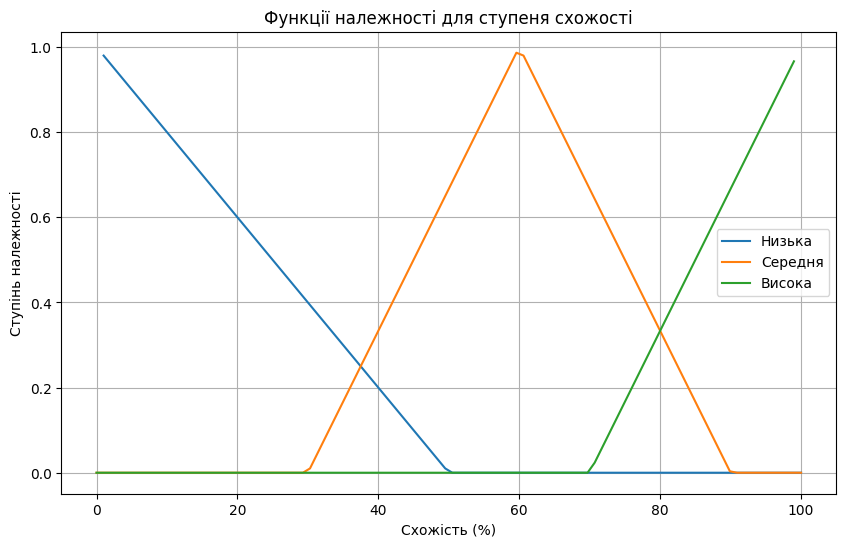

In [20]:
def create_comparison_table(df, threshold=75):
    results = []

    for i in range(len(df)):
        name_jw = fuzz.token_sort_ratio(df.loc[i, 'Beer Name (Full)'], df.loc[i, 'matches']) / 100
        name_soundex = soundex_similarity(df.loc[i, 'Beer Name (Full)'], df.loc[i, 'matches']) / 100

        distance = damerau_levenshtein_distance(df.loc[i, 'Beer Name (Full)'], df.loc[i, 'matches'])
        probability = calculate_similarity(name_jw, name_soundex)
        decision = "Належить" if probability * 100 >= threshold else "Не належить"

        results.append([
            df.loc[i, 'Beer Name (Full)'], df.loc[i, 'matches'],
            round(name_jw, 2), round(name_soundex, 2),
            distance, f"{int(probability * 100)}%", decision
        ])

    headers = [
        "Термін 1 (Beer Name (Full))", "matches",
        "Name JW", "Name Soundex",
        "Damerau-Levenshtein", "Ймовірність належності", "Рішення"
    ]

    table = tabulate(results, headers=headers, tablefmt="grid", stralign="center", numalign="center")
    print("\nПриклад виводу системи:")
    print(table)
    savetoscv = input("Зберегти результати в CSV? (y/n): ").strip().lower()
    if savetoscv == 'y':
        output_df = pd.DataFrame(results, columns=headers)
        output_df.to_csv("comparison_results.csv", index=False)
        print("Результати збережено в comparison_results.csv")
    else:
        print("Результати не збережено.")

# Виклик функції для створення таблиці
create_comparison_table(data, threshold=40)

# Візуалізація функції належності
x = np.linspace(0, 100, 100)

def trimf(x, params):
    a, b, c = params
    return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)

low = trimf(x, [0, 0, 50])
medium = trimf(x, [30, 60, 90])
high = trimf(x, [70, 100, 100])

plt.figure(figsize=(10, 6))
plt.plot(x, low, label='Низька')
plt.plot(x, medium, label='Середня')
plt.plot(x, high, label='Висока')
plt.title('Функції належності для ступеня схожості')
plt.xlabel('Схожість (%)')
plt.ylabel('Ступінь належності')
plt.legend()
plt.grid(True)
plt.show()